In [10]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_curve, auc
import pickle 
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

## Load data

In [2]:
df = pd.read_csv('irritation.csv')
df.head()

,SMILES,Class
0,CC#CC,1
1,CCC=C,1
2,O=CC=O,1
3,CCC=O,1
4,FCC#N,1


### Converting to MACCS fp

In [3]:
smiles = df['SMILES'].to_list()

In [4]:
mols = [Chem.MolFromSmiles(i) for i in smiles]
MACCS_list = []
header = ['bit' + str(i) for i in range(167)]
for i in range(len(mols)):
    ds = list(MACCSkeys.GenMACCSKeys(mols[i]).ToBitString())
    MACCS_list.append(ds)
df2 = pd.DataFrame(MACCS_list,columns=header)
df2.insert(loc=0, column='smiles', value=smiles)
df2.head(3)

,smiles,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,...,bit157,bit158,bit159,bit160,bit161,bit162,bit163,bit164,bit165,bit166
0,CC#CC,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,CCC=C,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,O=CC=O,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0


### Split data into predictor and target

In [5]:
X = df2.iloc[:, 1:168].astype(int)
y = np.array(df[['Class']]).ravel()

In [6]:
X.shape

(5220, 167)

In [54]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=10)

In [55]:
clf = GradientBoostingClassifier(random_state=10)
clf.fit(Xtrain, ytrain)

GradientBoostingClassifier(random_state=10)

In [206]:
clf.score(Xtest, ytest)

0.9339080459770115

In [37]:
ypred = clf.predict(Xtest)

In [38]:
f1 = f1_score(ytest, ypred)
print(f1)

0.9559668155711551


### Hyperparameter optimization

In [8]:
parameters = {
    "learning_rate": [0.01, 0.1, 0.2],
    "min_samples_leaf": [1, 5, 10],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 1.0],
    }

In [212]:
opt_clf = GridSearchCV(GradientBoostingClassifier(random_state=10), parameters, cv=10, n_jobs=-1)

In [213]:
opt_clf.fit(Xtrain, ytrain)

GridSearchCV(cv=10, estimator=GradientBoostingClassifier(random_state=10),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 8],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [1, 5, 10],
                         'subsample': [0.5, 1.0]})

In [214]:
opt_clf.best_params_

{'learning_rate': 0.1,
 'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 10,
 'subsample': 0.5}

### Train model with optimized hyperparameters

In [56]:
opt_model = GradientBoostingClassifier(learning_rate=0.1, 
                                       max_depth=8, 
                                       max_features='sqrt',
                                       min_samples_leaf=10, 
                                       subsample=0.5, 
                                       random_state=10).fit(Xtrain, ytrain)

In [57]:
opt_model.score(Xtest, ytest)

0.9473180076628352

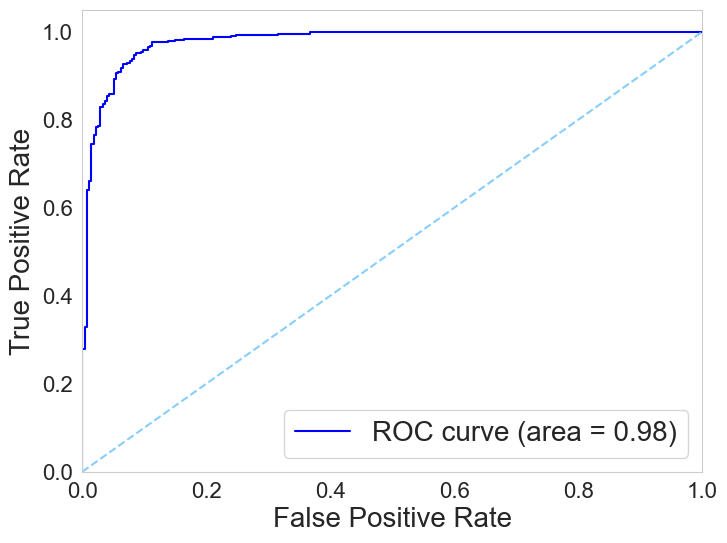

In [76]:
# Predict probabilities for the test set
y_pred = opt_model.predict_proba(Xtest)[:, 1]

fpr, tpr, thresholds = roc_curve(ytest, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='#87CEFA', linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)
plt.legend(loc='lower right', fontsize = 20)
plt.tick_params(axis='both', labelsize=16)

plt.grid()
plt.savefig('irr_ML.svg', dpi=700, bbox_inches='tight')
plt.show()

### Feature importance analysis

In [71]:
importance = opt_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': df2.iloc[:,1:168].columns, 'Importance': importance})

feature_importance_df

,Feature,Importance
0,bit0,0.000000
1,bit1,0.000000
2,bit2,0.000000
3,bit3,0.000000
4,bit4,0.000000
...,...,...
162,bit162,0.023359
163,bit163,0.003088
164,bit164,0.002684
165,bit165,0.005666


In [72]:
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
filtered_importance_df = feature_importance_df[feature_importance_df['Importance'] >= 0.03]

C:\Users\Anastasia\AppData\Local\Temp\ipykernel_20496\3348443405.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=filtered_importance_df, palette='Blues', color='steelblue')


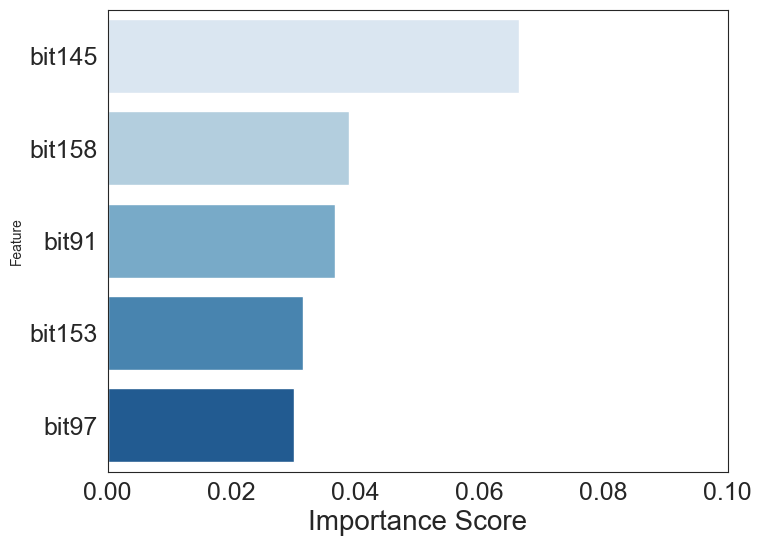

In [75]:
sns.set_style("white")

plt.figure(figsize=(8, 6))

sns.barplot(x='Importance', y='Feature', data=filtered_importance_df, palette='Blues', color='steelblue')
sns.set_style("whitegrid")
plt.xlabel('Importance Score', fontsize = 20)

plt.xlim(0, 0.1)
plt.tick_params(axis='both', labelsize=18)
plt.savefig('FI_irr.svg', dpi=700)
plt.show()

## Case study

### Load generated SMILES

In [40]:
smiles = pd.read_csv('smiles_noML_1000.csv')['Smiles'].to_list()

### Convert SMILES to MACCS keys

In [41]:
mols = [Chem.MolFromSmiles(i) for i in smiles]
MACCS_list = []
header = ['bit' + str(i) for i in range(167)]
for i in range(len(mols)):
    ds = list(MACCSkeys.GenMACCSKeys(mols[i]).ToBitString())
    MACCS_list.append(ds)
df3 = pd.DataFrame(MACCS_list,columns=header)
df3.insert(loc=0, column='smiles', value=smiles)
df3.head(3)

,smiles,bit0,bit1,bit2,bit3,bit4,bit5,bit6,bit7,bit8,...,bit157,bit158,bit159,bit160,bit161,bit162,bit163,bit164,bit165,bit166
0,O=CC(=O)N(c1ccc(CC(=O)O)cc1)C(O)F,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0
1,COCCc1cc(Cl)c(CC(=O)O)c(NN)c1C1CC1,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,0
2,C#CC(F)(C#N)Cc1cccc(C(NN)C(=O)O)c1,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,1,1,1,0


In [42]:
X = np.array(df3.iloc[:, 1:168])

### Calculate probability of being toxic for all generated molecules

In [43]:
irritation = opt_model.predict_proba(X)[:, 1]
irritation

c:\Users\Anastasia\miniconda3\envs\drops\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


array([0.62185534, 0.08739139, 0.70814112, ..., 0.71452656, 0.86971792,
       0.78287412])

In [44]:
irritation_mean = np.mean(irritation)
irritation_mean

0.5885024118673322

### Calculating average probability of being toxic for molecules generated by FREED++

In [45]:
irr_noML = [0.6545334707629263, 0.5438266649512228, 0.4739401827828259, 0.5223554261551543, 0.5885024118673322]
irr_noML_mean = np.mean(irr_noML)
irr_noML_mean

0.5566316313038924

In [46]:
std_noML = np.std(irr_noML)
std_noML

0.06128167407045757

### Save model

In [9]:
pkl_filename = "pickle_model_irritation.pkl"

In [10]:
with open(pkl_filename, 'wb') as file: 
    pickle.dump(opt_model, file)